<a href="https://colab.research.google.com/github/wizmik12/DGPMIL/blob/main/DGPMIL_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Gaussian Processes
## Introduction

In this notebook, we provide a GPyTorch implementation of deep Gaussian processes for Multiple Instance Learning. We show the performance in a synthetic MNIST problem. First, we install the gpytorch package with pip and import the required functions.

In [ ]:
# Install gpytorch
!pip install gpytorch

     |████████████████████████████████| 286kB 20.2MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.4.0-py2.py3-none-any.whl size=477826 sha256=f7df09f011e7f32bc7a79dff347f69285ec245099fce215529919c74ac9e0a3a
  Stored in directory: /root/.cache/pip/wheels/fd/f5/39/404e1875f841e8a999e94a7efa17f6ef900298be5452b63b0c
Successfully built gpytorch


In [ ]:
# For using GPU in the Colab
%set_env CUDA_VISIBLE_DEVICES=0

#Torch and gpytorch import
import torch
import tqdm
import gpytorch
from torch.nn import Linear
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

# For loading MNIST
import keras

#Some python libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, log_loss
import seaborn as sns
import pandas as pd

env: CUDA_VISIBLE_DEVICES=0


In [ ]:
# Import gpytorch for DGPs
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

### Loading Data:

We load the MNIST and create a synthetic Multiple Instance Learning problem.

In [ ]:
# For reproducibility 
np.random.seed(12)

# Load data from keras
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

# Reshape and normalize data
train_x = train_x.reshape(-1, 784).astype('float64')
test_x = test_x.reshape(-1, 784).astype('float64')

train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)

train_x = train_x/255
test_x = test_x/255

# We convert the problem into a binaryo one
negative_train_x = train_x[train_y.ravel()!=1]
np.random.shuffle(negative_train_x)
positive_train_x = train_x[train_y.ravel()==1]
np.random.shuffle(positive_train_x)

def create_bags(list_, balance=1, pos=False):
    """ This function groups instances in bags.
    Parameters
    ----------
    list_ : list of instances.
    balance: whether we want to use all the instances.
    pos: if true, the bags are created using another size.

    Return
    -----------
    bags: list of bag index for each instance.
    """
    # We initialize selecting between 1 and 5 elements for the first bag
    n = np.random.randint(1,5,1)[0]
    i = n # Position in the list of instances
    j = 0 # Index of the bag
    bags = np.array([n *[0]]).reshape(-1,) # Add indexes
    while i<int(len(list_)/balance):
        # Select a different number of instances for the bag depending
        # if it is a positive bag or negative
        if pos==True:
          n = np.random.randint(1,10,1)[0]
        else:
          n = np.random.randint(10,30,1)[0]
        # Check if we are selecting more indexes than elements
        if n+i >= len(list_):
            n = len(list_) - i
        j  = j+1 # Update the bag index
        bags = np.hstack((bags, np.array(n*[j]))) # Add the indexes
        i = i + n # Update the position in the list of instances
    return bags

# We create indexes bags for positive elements and negative.
# We use a different number of elements per bag for positive instances.
negative_bags = create_bags(negative_train_x)
positive_bags = create_bags(positive_train_x, pos=True)

# We group all the bag indexes of negative and positive instances.
bag_index_train = np.hstack((negative_bags, positive_bags[:len(positive_bags)]))
# We group the train instances and create the true instance labels.
train_x = torch.Tensor(np.vstack((negative_train_x, positive_train_x[:len(positive_bags)])))
train_y = np.hstack((np.zeros(len(negative_train_x)), np.ones(len(positive_bags))))
# Indexes of train_x this is useful for the DGPMIL method training in minibatches.
train_index = torch.Tensor(np.arange(len(train_x))) 
# Bag labels
T = np.array([1 if np.any(train_y[bag_index_train==i]==1) else 0 for i in np.unique(bag_index_train)])
# Bag label per instance
y_bag_train = torch.Tensor(np.array([T[i] for i in bag_index_train]))

## Transform the test into the binary problem and create bags
negative_test_x = test_x[test_y.ravel()!=1]
np.random.shuffle(negative_test_x)
positive_test_x = test_x[test_y.ravel()==1]
np.random.shuffle(positive_test_x)

negative_bags_test = create_bags(negative_test_x)
positive_bags_test = create_bags(positive_test_x, pos=True)

test_x = torch.Tensor(np.vstack((negative_test_x, positive_test_x)))
test_y = np.hstack((np.zeros(len(negative_test_x)), np.ones(len(positive_test_x))))

bag_index_test = np.hstack((negative_bags_test, positive_bags_test[:len(positive_bags_test)]))
T_test = np.array([1 if np.any(test_y[bag_index_test==i]==1) else 0 for i in np.unique(bag_index_test)])

train_y = torch.Tensor(train_y)
test_y = torch.Tensor(test_y)

# We initialize the distribution q(y) with the bag labels
q_y = np.zeros(len(train_x))
q_y[y_bag_train==0]=0.0
q_y[y_bag_train==1]=1.0
q_y = torch.Tensor(np.vstack((1-q_y, q_y)).T)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
import collections
count = collections.Counter(T)
print("Training **** \nNegative bags: ", count[0], "\nPositive bags: " , count[1])
count = collections.Counter(T_test)
print("Test ******* \nNegative bags: ", count[0], "\nPositive bags: " , count[1])

Training **** 
Negative bags:  1416 
Positive bags:  1333
Test ******* 
Negative bags:  229 
Positive bags:  231


We show four bags of example:

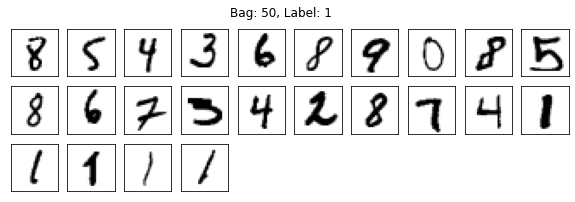

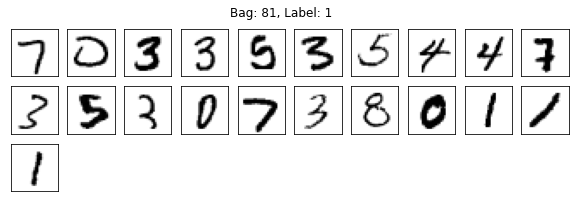

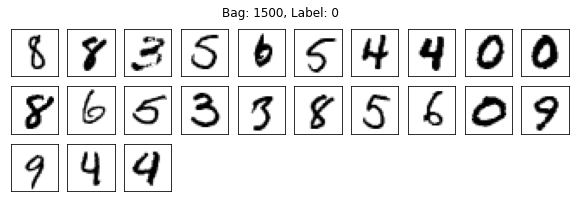

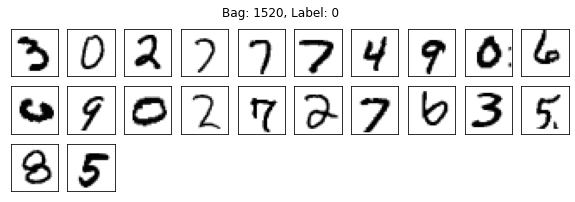

In [ ]:
def plotbag(X, bag_indexs, bag_index, y):
  """ This function plots bags.
    Parameters
    ----------
    X : list of instances.
    bag_indexs: list with the bag indexes.
    bag_index: the index of the bag we want to plot.
    y: true instance labels.
    """
  # Select the instances of the bag
  X = X[bag_indexs==bag_index]
  # Calculate the bag label
  y = int(np.max(np.unique(y[bag_indexs==bag_index])))

  # Plot the figure
  fig = plt.figure(figsize=(10,3))
  title = 'Bag: ' + str(bag_index) + ', Label: ' + str(y)
  fig.suptitle(title)
  rows = int(np.ceil(len(X)/10))
  for i in range(len(X)):
      ax = fig.add_subplot(rows, 10, i+1)
      plt.xticks([])
      plt.yticks([])
      ax.imshow(X[i].reshape(28,28), cmap='gray_r')
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
  plt.savefig("bag"+str(bag_index)+".png")
  plt.show()

# Plot 4 different bags
plotbag(train_x, bag_index_train, 50, train_y)
plotbag(train_x, bag_index_train, 81, train_y)
plotbag(train_x, bag_index_train, 1500, train_y)
plotbag(train_x, bag_index_train, 1520, train_y)

Create the data loader and check if there is a gpu available.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Use the GPU if it is available
train_y = torch.Tensor(train_y)
if torch.cuda.is_available():
    train_x, train_index, test_x, test_y = train_x.cuda(), train_index.cuda(), test_x.cuda(), test_y.cuda()
    y_true, y_bag_train = train_y.cuda(), y_bag_train.cuda()
    q_y = q_y.cuda()

# Train loader for the mil dataset, we also create another without shuffle for
# computing q(y).
train_dataset_mil = TensorDataset(train_x, train_index)
train_loader_mil = DataLoader(train_dataset_mil, batch_size=512, shuffle=True)
train_loader_mil_noshuf = DataLoader(train_dataset_mil, batch_size=512, shuffle=False)

# Train loader for training the DGP with bag labels.
train_dataset_bag_labels = TensorDataset(train_x, y_bag_train)
train_loader_bag_labels = DataLoader(train_dataset_bag_labels, batch_size=512, shuffle=True)

# Train loader for training the DGP with true instance labels.
train_dataset_true = TensorDataset(train_x, y_true)
train_loader_true = DataLoader(train_dataset_true, batch_size=512, shuffle=True)

# Test loader for instance classification assessment.
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
def predict_bags(predictions, bag_index_test):
    pred_bags = np.zeros(len(np.unique(bag_index_test)))
    for ib, b in enumerate(np.unique(bag_index_test)):
        preds = predictions[bag_index_test==b]
        pred_bags[int(ib)] = np.max(preds)
    return np.array(pred_bags)

def bag_metrics(model, X, y_true, index, model_name):
    predictive_means, _, _ = model.predict(X)
    prob = predictive_means.mean(0).cpu().numpy()

    pred_bags = predict_bags(prob, index)

    ll = log_loss(y_true, pred_bags)
    pred = np.zeros(len(y_true))
    pred[pred_bags>0.5] = 1
    acc = np.mean(pred==y_true)
    f1 = f1_score(y_true, pred)

    return {'model': model_name, 'acc': acc, 'log_loss': ll, 'f1_score': f1}

## Defining GP layers

We create the GP layers with RBF kernel etc:

In [ ]:
class DeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super(DeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

        self.linear_layer = Linear(input_dims, 1)

    def forward(self, x):
        mean_x = self.mean_module(x) # self.linear_layer(x).squeeze(-1)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, *other_inputs, **kwargs):
        """
        Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
        easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
        hidden layer's outputs and the input data to hidden_layer2.
        """
        if len(other_inputs):
            if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
                x = x.rsample()

            processed_inputs = [
                inp.unsqueeze(0).expand(self.num_samples, *inp.shape)
                for inp in other_inputs
            ]

            x = torch.cat([x] + processed_inputs, dim=-1)
        return super().__call__(x, are_samples=bool(len(other_inputs)))

## Building the DGPMIL

We proceed to create the deep structure of gaussian processes. We stack GP layers.

In [ ]:
class DeepGPMIL(DeepGP):
    def __init__(self, x_train_shape, dims, num_inducing=128):
        # Define L hidden-layers of a L+1-layer DGP
        # dims is a list with the dimensionality of each hidden layer, 
        # we consider that the first layer has dimnesionality of data.
        # For example, if dims = [10], we build the 2-layer DGP. 
        # The first layer has dimensionality x_train_shape and the second
        # 10.
        dims.append(None) # The last layer has None output_dims
        means = (len(dims)-1)*['linear'] + ['constant'] # The last layer with constant mean
        hidden_layers = torch.nn.ModuleList([DeepGPHiddenLayer(
            input_dims=x_train_shape,
            output_dims=dims[0],
            mean_type=means[0],
            num_inducing=num_inducing,
            )])
        for l in range(len(dims)-1):
            hidden_layers.append(DeepGPHiddenLayer(
                input_dims=hidden_layers[-1].output_dims,
                output_dims=dims[l+1],
                mean_type=means[l+1],
                num_inducing = num_inducing,
                ))

        super().__init__()

        self.hidden_layers = hidden_layers
        # We set the likelihood to the Bernoulli because
        # DGPMIL addresses the binary MIL problem.
        self.likelihood = gpytorch.likelihoods.BernoulliLikelihood()

    def forward(self, inputs):
        output = self.hidden_layers[0](inputs)
        for hid_layer in self.hidden_layers[1:]:
            output = hid_layer(output)
        return output

    def predict(self, test_loader):
        with torch.no_grad():
            mus = []
            variances = []
            lls = []
            for x_batch, y_batch in test_loader:
                preds = self.likelihood(self(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                lls.append(self.likelihood.log_marginal(y_batch, self(x_batch)))

        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1), torch.cat(lls, dim=-1)


## DGPMIL ELBO

We implement the ELBO for the MIL problem in Deep Gaussian Processes given in eq() of the paper. With a fixed $\mathrm{q}(\mathbf{y})$, we optimize w.r.t. the variational parameters $\{\mathbf{V}^l\}^L_{l=1}$ of $\{\mathrm{q}(\mathbf{U}^l)\}^L_{l=1}$, kernel hyperparameters $\{\Theta^l\}^L_{l=1}$ and inducing locations $\{\mathbf{Z}^{l-1}\}^L_{l=1}$:

\begin{equation}
\mathrm{ELBO}\left(\{\mathbf{V}^l\}^L_{l=1}, \{\Theta^l\}^L_{l=1},\{\mathbf{Z}^{l-1}\}^L_{l=1}\right)= \sum_{n=1}^N q_n \mathbb{E}_{\mathrm{q}(f^L_n)}\left[\log\mathrm{p}(y_n=1|f^L_{n})\right] + (1-q_n) \mathbb{E}_{\mathrm{q}(f^L_n)}\left[\log\mathrm{p}(y_n=0|f^L_{n})\right] \\ - \sum^L_{l=1} \mathrm{KL}\left(\mathrm{q}(\mathbf{U}^l)||\mathrm{p}(\mathbf{U}^l)\right) + \text{const}.
\end{equation}


In [ ]:
#!/usr/bin/env python3

from abc import ABC, abstractmethod
from gpytorch.mlls.marginal_log_likelihood import MarginalLogLikelihood

class _ApproximateMarginalLogLikelihood_MIL(MarginalLogLikelihood, ABC):
    r"""
    An approximate marginal log likelihood (typically a bound) for approximate GP models in MIL.
    We expect that :attr:`model` is a :obj:`gpytorch.models.ApproximateGP`.
    Args:
        :attr:`likelihood` (:obj:`gpytorch.likelihoods.Likelihood`):
            The likelihood for the model
        :attr:`model` (:obj:`gpytorch.models.ApproximateGP`):
            The approximate GP model
        :attr:`num_data` (int):
            The total number of training data points (necessary for SGD)
        :attr:`beta` (float - default 1.):
            A multiplicative factor for the KL divergence term.
            Setting it to 1 (default) recovers true variational inference
            (as derived in `Scalable Variational Gaussian Process Classification`_).
            Setting it to anything less than 1 reduces the regularization effect of the model
            (similarly to what was proposed in `the beta-VAE paper`_).
        :attr:`combine_terms` (bool):
            Whether or not to sum the expected NLL with the KL terms (default True)
    """

    def __init__(self, likelihood, model, num_data, beta=1.0, combine_terms=True):
        super().__init__(likelihood, model)
        self.combine_terms = combine_terms
        self.num_data = num_data
        self.beta = beta
        

    @abstractmethod
    def _log_likelihood_term(self, approximate_dist_f, target, **kwargs):
        raise NotImplementedError

    def forward(self, approximate_dist_f, target, **kwargs):
        r"""
        Computes the Variational ELBO given :math:`q(\mathbf f)` and `\mathbf y`.
        Calling this function will call the likelihood's `expected_log_prob` function.
        Args:
            :attr:`approximate_dist_f` (:obj:`gpytorch.distributions.MultivariateNormal`):
                :math:`q(\mathbf f)` the outputs of the latent function (the :obj:`gpytorch.models.ApproximateGP`)
            :attr:`target` (`torch.Tensor`):
                :math:`\mathbf y` The target values
            :attr:`**kwargs`:
                Additional arguments passed to the likelihood's `expected_log_prob` function.
        """
        # Get likelihood term and KL term
        num_batch = approximate_dist_f.event_shape[0]

        # Tensor with zeros and ones for predicting the lik term
        target0 = torch.zeros(len(target)).cuda()
        target1 = torch.ones(len(target)).cuda()

        if torch.cuda.is_available():
          target0, target1 = target0.cuda(), target1.cuda()

        # Lik term
        log_likelihood0 = self._log_likelihood_term(approximate_dist_f, target0, **kwargs)
        log_likelihood1 = self._log_likelihood_term(approximate_dist_f, target1, **kwargs)

        y0 = target[:,0].repeat(log_likelihood0.shape[0],1)
        y1 = target[:,1].repeat(log_likelihood0.shape[0],1)

        log_likelihood = (log_likelihood0*y0 + log_likelihood1*y1).sum(-1).div(num_batch)

        # KL term
        kl_divergence = self.model.variational_strategy.kl_divergence().div(self.num_data / self.beta)

        # Add any additional registered loss terms
        added_loss = torch.zeros_like(log_likelihood)
        had_added_losses = False
        for added_loss_term in self.model.added_loss_terms():
            added_loss.add_(added_loss_term.loss())
            had_added_losses = True

        # Log prior term
        log_prior = torch.zeros_like(log_likelihood)
        for _, prior, closure, _ in self.named_priors():
            log_prior.add_(prior.log_prob(closure()).sum().div(self.num_data))

        if self.combine_terms:
            return log_likelihood - kl_divergence + log_prior - added_loss
        else:
            if had_added_losses:
                return log_likelihood, kl_divergence, log_prior.div(self.num_data), added_loss
            else:
                return log_likelihood, kl_divergence, log_prior.div(self.num_data)


class VariationalELBO_MIL(_ApproximateMarginalLogLikelihood_MIL):
    r"""
    The variational evidence lower bound (ELBO). This is used to optimize
    variational Gaussian processes (with or without stochastic optimization).
    .. math::
       \begin{align*}
          \mathcal{L}_\text{ELBO} &=
          \mathbb{E}_{p_\text{data}( y, \mathbf x )} \left[
            \mathbb{E}_{p(f \mid \mathbf u, \mathbf x) q(\mathbf u)} \left[  \log p( y \! \mid \! f) \right]
          \right] - \beta \: \text{KL} \left[ q( \mathbf u) \Vert p( \mathbf u) \right]
          \\
          &\approx \sum_{i=1}^N \mathbb{E}_{q( f_i)} \left[
            \log p( y_i \! \mid \! f_i) \right] - \beta \: \text{KL} \left[ q( \mathbf u) \Vert p( \mathbf u) \right]
       \end{align*}
    where :math:`N` is the number of datapoints, :math:`q(\mathbf u)` is the variational distribution for
    the inducing function values, :math:`q(f_i)` is the marginal of
    :math:`p(f_i \mid \mathbf u, \mathbf x_i) q(\mathbf u)`,
    and :math:`p(\mathbf u)` is the prior distribution for the inducing function values.
    :math:`\beta` is a scaling constant that reduces the regularization effect of the KL
    divergence. Setting :math:`\beta=1` (default) results in the true variational ELBO.
    For more information on this derivation, see `Scalable Variational Gaussian Process Classification`_
    (Hensman et al., 2015).
    :param ~gpytorch.likelihoods.Likelihood likelihood: The likelihood for the model
    :param ~gpytorch.models.ApproximateGP model: The approximate GP model
    :param int num_data: The total number of training data points (necessary for SGD)
    :param float beta: (optional, default=1.) A multiplicative factor for the KL divergence term.
        Setting it to 1 (default) recovers true variational inference
        (as derived in `Scalable Variational Gaussian Process Classification`_).
        Setting it to anything less than 1 reduces the regularization effect of the model
        (similarly to what was proposed in `the beta-VAE paper`_).
    :param bool combine_terms: (default=True): Whether or not to sum the
        expected NLL with the KL terms (default True)
    Example:
        >>> # model is a gpytorch.models.ApproximateGP
        >>> # likelihood is a gpytorch.likelihoods.Likelihood
        >>> mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=100, beta=0.5)
        >>>
        >>> output = model(train_x)
        >>> loss = -mll(output, train_y)
        >>> loss.backward()
    .. _Scalable Variational Gaussian Process Classification:
        http://proceedings.mlr.press/v38/hensman15.pdf
    .. _the beta-VAE paper:
        https://openreview.net/pdf?id=Sy2fzU9gl
    """

    def _log_likelihood_term(self, variational_dist_f, target, **kwargs):
        return self.likelihood.expected_log_prob(target, variational_dist_f, **kwargs)

    def forward(self, variational_dist_f, target, **kwargs):
        r"""
        Computes the Variational ELBO given :math:`q(\mathbf f)` and :math:`\mathbf y`.
        Calling this function will call the likelihood's :meth:`~gpytorch.likelihoods.Likelihood.expected_log_prob`
        function.
        :param ~gpytorch.distributions.MultivariateNormal variational_dist_f: :math:`q(\mathbf f)`
            the outputs of the latent function (the :obj:`gpytorch.models.ApproximateGP`)
        :param torch.Tensor target: :math:`\mathbf y` The target values
        :param kwargs: Additional arguments passed to the
            likelihood's :meth:`~gpytorch.likelihoods.Likelihood.expected_log_prob` function.
        :rtype: torch.Tensor
        :return: Variational ELBO. Output shape corresponds to batch shape of the model/input data.
        """
        return super().forward(variational_dist_f, target, **kwargs)

## Compute the distribution of instance labels

The following function updates the distribution of the instance labels $\mathrm{q}(\mathbf{y})=\prod^N_{n=1}\mathrm{Ber}(y_n;q_n)$. This is given in the paper by eq() in the paper. With the DGP fixed we update the distribution of the instance labels by:

\begin{equation}
q_n \leftarrow \sigma\left(\mathbb{E}_{\mathrm{q}(f^L_n)}\left[f^L_n\right]+\log H\cdot (2 T_b+ \max\{q_i\}_{i\in b-n}-2 T_b \max\{q_i\}_{i\in b-n} -1) \right)
\end{equation}


In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))
  
def update_q_y(q_y, model, X, ind_bag, T):
    """ This function groups instances in bags.
    Parameters
    ----------
    q_y : (N,2) Tensor with current q(y) distribution.
    model: gpytorch model
    ind_bag: list with bag indexes.
    T: bag labels for each bag.

    Return
    -----------
    (N,2) Tensor with the updated q_y distribution.
    """
    H = 100
    #Prob of positive class
    q_n = q_y[:,1]
    #Mean of the latent variable
    with torch.no_grad():
        mean_f_L = []
        for x_batch, y_batch in X:
            mean_f_L.append(model(x_batch).mean.mean(0))
    mean_f_L = torch.cat(mean_f_L, 0)
    # Initialize the updated probabilities and the expectation max 
    q_n_estimated = torch.zeros(len(q_n))
    Emax = torch.zeros(len(q_n))
    if torch.cuda.is_available():
         q_n_estimated, Emax = q_n_estimated.cuda(), Emax.cuda()
    # Update the probabilities for each bag
    for b in np.unique(ind_bag):
        mask_bag = ind_bag == b
        q_n_bag = q_n[mask_bag]
        max_bag = torch.argmax(q_n_bag)
        tmp = torch.repeat_interleave(q_n_bag[max_bag], len(q_n_bag))
        q_n_bag[max_bag] = 0
        max_bag2 = torch.argmax(q_n_bag)
        tmp[max_bag] = q_n_bag[max_bag2]
        Emax[mask_bag] = tmp
        q_n_estimated[mask_bag] = torch.sigmoid(mean_f_L[mask_bag] + np.log(H) * (2 * T[mask_bag][0] + Emax[mask_bag] -
                                                  2 * T[mask_bag][0] * Emax[mask_bag] - 1))
    return torch.vstack((1-q_n_estimated, q_n_estimated)).T

## Defining DGP and DGPMIL models

We define both DGP and DGPMIL with 2, 3 and 4 layers for the comparison. In the DGP we consider two different models: DGP using the true instance labels and DGP using the bag labels for each instance. We can check that the DGPMIL perform in between this two model being close to the DGP with true labels and modeling the uncertainty quite better than using the noisy bag labels.

## Training/Testing DGP



In [ ]:
# For reproducibility, we set a seed, 
# notice that this program will run in the GPU which 
# may produce different results for different runs.
torch.manual_seed(123)

DGP_metrics_true = [] # We store the metrics for each DGP.
DGP_metrics_true_bag = [] # We store the metrics for each DGP.
DGPtrue_models = []

# We calculate a 2-layer, 3-layer and 4-layer DGP
for l in range(0,4):
  # We define the DGP model
  model = DeepGPMIL(train_x.shape[1], l*[7]) 

  if torch.cuda.is_available():
    model = model.cuda()
  
  num_samples = 10
  num_epochs = 15

  optimizer = torch.optim.Adam([
  {'params': model.parameters()},
  ], lr=0.01)
  # We use the DGP ELBO
  mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, y_bag_train.numel()))

  epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")

  for i in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(train_loader_true, desc="Minibatch", leave=False)
    
    # We train in minibatches
    for x_batch, y_batch in minibatch_iter:
      with gpytorch.settings.num_likelihood_samples(num_samples):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        minibatch_iter.set_postfix(loss=loss.item())

    print('Iter %d - Loss: %.3f' % (i + 1, loss.item()))

  # Prediction
  model.eval()
  with gpytorch.settings.num_likelihood_samples(100):
    predictive_means, predictive_variances, test_lls = model.predict(test_loader)
  observed_prob = predictive_means.mean(0)
  test_lls = test_lls.mean(0)
  observed_pred = observed_prob.round()

  # Evaluation
  acc = ((observed_pred==test_y).sum(0)/len(test_y)).cpu().numpy()
  f1  =  f1_score(test_y.cpu().numpy(), observed_pred.cpu().numpy())
  test_ll = test_lls.mean().cpu().numpy()
  log_loss_metric = log_loss(test_y.cpu().numpy(), observed_prob.cpu().numpy())
  print("******",l+1,"-layer DGP with true instance labels******")
  print('Accuracy: ',acc)
  print('Test log likelihood: ',test_ll)
  print("F1 score: ", f1)
  print("Log loss: ", log_loss_metric)

  # Bag evaluation
  bag_results = bag_metrics(model, test_loader, T_test, bag_index_test, 'True instance labels')
  print("Bag results: ", bag_results)
  print("****************")

  # We save the metrics
  DGP_metrics_true.append({'model': 'True instance labels', 'acc': acc, 'test_ll': test_ll, 'f1': f1, 'log_loss': log_loss_metric})
  DGP_metrics_true_bag.append(bag_results)
  DGPtrue_models.append(model)

Iter 1 - Loss: 0.461


Iter 2 - Loss: 0.368


Iter 3 - Loss: 0.470


Iter 4 - Loss: 0.260


Iter 5 - Loss: 0.457


Iter 6 - Loss: 0.300


Iter 7 - Loss: 0.275


Iter 8 - Loss: 0.384


Iter 9 - Loss: 0.274


Iter 10 - Loss: 0.382


Iter 11 - Loss: 0.403


Iter 12 - Loss: 0.294


Iter 13 - Loss: 0.272


Iter 14 - Loss: 0.358


Iter 15 - Loss: 0.315

****** 1 -layer DGP with true instance labels******
Accuracy:  0.8865
Test log likelihood:  -0.3537716
F1 score:  0.0
Log loss:  0.3537716565951705
Bag results:  {'model': 'True instance labels', 'acc': 0.49782608695652175, 'log_loss': 1.1512273222613234, 'f1_score': 0.0}
****************


Iter 1 - Loss: 0.276


Iter 2 - Loss: 0.199


Iter 3 - Loss: 0.159


Iter 4 - Loss: 0.121


Iter 5 - Loss: 0.116


Iter 6 - Loss: 0.094


Iter 7 - Loss: 0.077


Iter 8 - Loss: 0.037


Iter 9 - Loss: 0.079


Iter 10 - Loss: 0.091


Iter 11 - Loss: 0.032


Iter 12 - Loss: 0.046


Iter 13 - Loss: 0.030


Iter 14 - Loss: 0.021


Iter 15 - Loss: 0.026

****** 2 -layer DGP with true instance labels******
Accuracy:  0.9921
Test log likelihood:  -0.02986434
F1 score:  0.9653964082347788
Log loss:  0.0297937630944798
Bag results:  {'model': 'True instance labels', 'acc': 0.9543478260869566, 'log_loss': 0.11823516455317752, 'f1_score': 0.9561586638830897}
****************


Iter 1 - Loss: 0.157


Iter 2 - Loss: 0.081


Iter 3 - Loss: 0.121


Iter 4 - Loss: 0.080


Iter 5 - Loss: 0.078


Iter 6 - Loss: 0.009


Iter 7 - Loss: 0.014


Iter 8 - Loss: 0.058


Iter 9 - Loss: 0.032


Iter 10 - Loss: 0.086


Iter 11 - Loss: 0.010


Iter 12 - Loss: 0.016


Iter 13 - Loss: 0.005


Iter 14 - Loss: 0.022


Iter 15 - Loss: 0.103

****** 3 -layer DGP with true instance labels******
Accuracy:  0.9948
Test log likelihood:  -0.020679835
F1 score:  0.9770723104056437
Log loss:  0.020148859927585
Bag results:  {'model': 'True instance labels', 'acc': 0.9695652173913043, 'log_loss': 0.0861226080292062, 'f1_score': 0.970464135021097}
****************


Iter 1 - Loss: 0.368


Iter 2 - Loss: 0.025


Iter 3 - Loss: 0.052


Iter 4 - Loss: 0.030


Iter 5 - Loss: 0.068


Iter 6 - Loss: 0.012


Iter 7 - Loss: 0.017


Iter 8 - Loss: 0.008


Iter 9 - Loss: 0.062


Iter 10 - Loss: 0.008


Iter 11 - Loss: 0.036


Iter 12 - Loss: 0.066


Iter 13 - Loss: 0.021


Iter 14 - Loss: 0.018


Iter 15 - Loss: 0.003

****** 4 -layer DGP with true instance labels******
Accuracy:  0.99549997
Test log likelihood:  -0.020121146
F1 score:  0.9800266311584555
Log loss:  0.01959915505195313
Bag results:  {'model': 'True instance labels', 'acc': 0.9869565217391304, 'log_loss': 0.05417018705624424, 'f1_score': 0.9871244635193133}
****************


In [ ]:
# For reproducibility, we set a seed, 
# notice that this program will run in the GPU which 
# may produce different results for different runs.
torch.manual_seed(123)

DGP_metrics = [] # We store the metrics for each DGP
DGP_metrics_bag = [] # We store the metrics for each DGP
DGPbag_models = []

# We calculate a 2-layer, 3-layer and 4-layer DGP
for l in range(0,4):
  model = DeepGPMIL(train_x.shape[1], l*[7])

  if torch.cuda.is_available():
    model = model.cuda()

  num_samples = 10
  num_epochs = 15


  optimizer = torch.optim.Adam([
  {'params': model.parameters()},
  ], lr=0.01)
  mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, y_bag_train.numel()))

  epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")


  for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    #minibatch_iter = tqdm.notebook.tqdm(train_loader_bag_labels, desc="Minibatch", leave=False)
    minibatch_iter = tqdm.notebook.tqdm(train_loader_bag_labels, desc="Minibatch", leave=False)
    
    for x_batch, y_batch in minibatch_iter:
      with gpytorch.settings.num_likelihood_samples(num_samples):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        minibatch_iter.set_postfix(loss=loss.item())


    print('Iter %d - Loss: %.3f' % (i + 1, loss.item()))
  
  # Prediction
  model.eval()
  with gpytorch.settings.num_likelihood_samples(100):
    predictive_means, predictive_variances, test_lls = model.predict(test_loader)
  observed_prob = predictive_means.mean(0)
  test_lls = test_lls.mean(0)
  observed_pred = observed_prob.round()
  
  # Evaluation
  acc = ((observed_pred==test_y).sum(0)/len(test_y)).cpu().numpy()
  f1  =  f1_score(test_y.cpu().numpy(), observed_pred.cpu().numpy())
  test_ll = test_lls.mean().cpu().numpy()
  log_loss_metric = log_loss(test_y.cpu().numpy(), observed_prob.cpu().numpy())

  print("******",l+1,"-layer DGP with bag instance labels******")
  print('Accuracy: ',acc)
  print('Test log likelihood: ',test_ll)
  print("F1 score: ", f1)
  print("Log loss: ", log_loss_metric)

  # Bag evaluation
  bag_results = bag_metrics(model, test_loader, T_test, bag_index_test, 'Bag labels')
  print("Bag results: ", bag_results)  
  print("****************")

  # We save the metrics
  DGP_metrics.append({'model': 'Bag labels', 'acc': acc, 'test_ll': test_ll, 'f1': f1, 'log_loss': log_loss_metric})
  DGP_metrics_bag.append(bag_results)
  DGPbag_models.append(model)

Iter 1 - Loss: 0.783


Iter 2 - Loss: 0.736


Iter 3 - Loss: 0.711


Iter 4 - Loss: 0.714


Iter 5 - Loss: 0.703


Iter 6 - Loss: 0.690


Iter 7 - Loss: 0.682


Iter 8 - Loss: 0.682


Iter 9 - Loss: 0.702


Iter 10 - Loss: 0.695


Iter 11 - Loss: 0.695


Iter 12 - Loss: 0.701


Iter 13 - Loss: 0.705


Iter 14 - Loss: 0.698


Iter 15 - Loss: 0.702

****** 1 -layer DGP with bag instance labels******
Accuracy:  0.1135
Test log likelihood:  -0.76302075
F1 score:  0.203861697350696
Log loss:  0.763020873427391
Bag results:  {'model': 'Bag labels', 'acc': 0.5021739130434782, 'log_loss': 0.6964385326754486, 'f1_score': 0.6685962373371925}
****************


Iter 1 - Loss: 0.747


Iter 2 - Loss: 0.690


Iter 3 - Loss: 0.648


Iter 4 - Loss: 0.622


Iter 5 - Loss: 0.618


Iter 6 - Loss: 0.616


Iter 7 - Loss: 0.624


Iter 8 - Loss: 0.621


Iter 9 - Loss: 0.595


Iter 10 - Loss: 0.627


Iter 11 - Loss: 0.686


Iter 12 - Loss: 0.606


Iter 13 - Loss: 0.562


Iter 14 - Loss: 0.612


Iter 15 - Loss: 0.617

****** 2 -layer DGP with bag instance labels******
Accuracy:  0.5318
Test log likelihood:  -0.6388372
F1 score:  0.3243867243867244
Log loss:  0.6387861901630182
Bag results:  {'model': 'Bag labels', 'acc': 0.5021739130434782, 'log_loss': 0.5227326507813931, 'f1_score': 0.6685962373371925}
****************


Iter 1 - Loss: 0.702


Iter 2 - Loss: 0.659


Iter 3 - Loss: 0.632


Iter 4 - Loss: 0.614


Iter 5 - Loss: 0.655


Iter 6 - Loss: 0.600


Iter 7 - Loss: 0.616


Iter 8 - Loss: 0.607


Iter 9 - Loss: 0.625


Iter 10 - Loss: 0.608


Iter 11 - Loss: 0.628


Iter 12 - Loss: 0.635


Iter 13 - Loss: 0.636


Iter 14 - Loss: 0.637


Iter 15 - Loss: 0.608

****** 3 -layer DGP with bag instance labels******
Accuracy:  0.99249995
Test log likelihood:  -0.59650606
F1 score:  0.9673202614379085
Log loss:  0.5959793841508508
Bag results:  {'model': 'Bag labels', 'acc': 0.9326086956521739, 'log_loss': 0.4302689551916, 'f1_score': 0.9366053169734151}
****************


Iter 1 - Loss: 0.706


Iter 2 - Loss: 0.703


Iter 3 - Loss: 0.691


Iter 4 - Loss: 0.689


Iter 5 - Loss: 0.694


Iter 6 - Loss: 0.689


Iter 7 - Loss: 0.626


Iter 8 - Loss: 0.663


Iter 9 - Loss: 0.614


Iter 10 - Loss: 0.628


Iter 11 - Loss: 0.650


Iter 12 - Loss: 0.608


Iter 13 - Loss: 0.664


Iter 14 - Loss: 0.606


Iter 15 - Loss: 0.628

****** 4 -layer DGP with bag instance labels******
Accuracy:  0.99039996
Test log likelihood:  -0.5863648
F1 score:  0.9586206896551724
Log loss:  0.5860627292380785
Bag results:  {'model': 'Bag labels', 'acc': 0.9326086956521739, 'log_loss': 0.36504866573454614, 'f1_score': 0.9368635437881874}
****************


In [ ]:
# For reproducibility, we set a seed, 
# notice that this program will run in the GPU which 
# may produce different results for different runs.
torch.manual_seed(123)

DGPMIL_metrics = [] # We store the metrics for each DGP
DGPMIL_metrics_bag = []
DGPMIL_models = [] # We store the models for each DGP

# We calculate a 2-layer, 3-layer and 4-layer DGP
for l in range(0,4):
  # We define the DGPMIL
  model = DeepGPMIL(train_x.shape[1], l*[7])

  if torch.cuda.is_available():
    model = model.cuda()

  num_samples = 10
  num_epochs = 15

  optimizer = torch.optim.Adam([
      {'params': model.parameters()},
  ], lr=0.01)

  # We use the ELBO for DGPMIL ELBO
  mll = DeepApproximateMLL(VariationalELBO_MIL(model.likelihood, model, train_y.numel()))

  epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")

  for i in epochs_iter:
      minibatch_iter = tqdm.notebook.tqdm(train_loader_mil, desc="Minibatch", leave=False)
      # Training in minibatches
      for x_batch, y_batch in minibatch_iter:
          with gpytorch.settings.num_likelihood_samples(num_samples):
              q_mb = q_y[y_batch.long()]
              optimizer.zero_grad()
              output = model(x_batch)
              loss = -mll(output, q_mb)
              loss.backward()
              optimizer.step()
              minibatch_iter.set_postfix(loss=loss.item())

      # Update instance labels
      q_y = update_q_y(q_y, model, train_loader_mil_noshuf, bag_index_train, y_bag_train)
              
      print('Iter %d - Loss: %.3f' % (i + 1, loss.item()))

  # Prediction
  model.eval()
  with gpytorch.settings.num_likelihood_samples(100):
    predictive_means, predictive_variances, test_lls = model.predict(test_loader)
  observed_prob = predictive_means.mean(0)
  test_lls = test_lls.mean(0)
  observed_pred = observed_prob.round()
  
  # Evaluation
  acc = ((observed_pred==test_y).sum(0)/len(test_y)).cpu().numpy()
  f1  =  f1_score(test_y.cpu().numpy(), observed_pred.cpu().numpy())
  log_loss_metric = log_loss(test_y.cpu().numpy(), observed_prob.cpu().numpy())
  test_ll = test_lls.mean().cpu().numpy()

  print("******",l+1,"-layer DGPMIL******")
  print('Accuracy: ',acc)
  print('Test log likelihood: ',test_ll)
  print("F1 score: ", f1)
  print("Log loss: ", log_loss_metric)

  # Bag evaluation
  bag_results = bag_metrics(model, test_loader, T_test, bag_index_test, 'DGPMIL')
  print("Bag results: ", bag_results)
  print("****************")

  DGPMIL_models.append(model)
  DGPMIL_metrics_bag.append(bag_results)
  DGPMIL_metrics.append({'model': 'DGPMIL', 'acc': acc, 'test_ll': test_ll, 'f1': f1, 'log_loss': log_loss_metric})

Iter 1 - Loss: 0.783


Iter 2 - Loss: 0.633


Iter 3 - Loss: 0.706


Iter 4 - Loss: 0.658


Iter 5 - Loss: 0.706


Iter 6 - Loss: 0.673


Iter 7 - Loss: 0.681


Iter 8 - Loss: 0.707


Iter 9 - Loss: 0.693


Iter 10 - Loss: 0.646


Iter 11 - Loss: 0.694


Iter 12 - Loss: 0.675


Iter 13 - Loss: 0.702


Iter 14 - Loss: 0.690


Iter 15 - Loss: 0.656

****** 1 -layer DGPMIL******
Accuracy:  0.8865
Test log likelihood:  -0.5500948
F1 score:  0.0
Log loss:  0.5500948140025139
Bag results:  {'model': 'DGPMIL', 'acc': 0.49782608695652175, 'log_loss': 0.7169393201070161, 'f1_score': 0.0}
****************


Iter 1 - Loss: 0.734


Iter 2 - Loss: 0.685


Iter 3 - Loss: 0.701


Iter 4 - Loss: 0.665


Iter 5 - Loss: 0.650


Iter 6 - Loss: 0.627


Iter 7 - Loss: 0.569


Iter 8 - Loss: 0.516


Iter 9 - Loss: 0.549


Iter 10 - Loss: 0.546


Iter 11 - Loss: 0.544


Iter 12 - Loss: 0.508


Iter 13 - Loss: 0.510


Iter 14 - Loss: 0.531


Iter 15 - Loss: 0.578

****** 2 -layer DGPMIL******
Accuracy:  0.98969996
Test log likelihood:  -0.2622577
F1 score:  0.954283177984909
Log loss:  0.26225711253583434
Bag results:  {'model': 'DGPMIL', 'acc': 0.9586956521739131, 'log_loss': 0.27486019816362556, 'f1_score': 0.9600000000000001}
****************


Iter 1 - Loss: 0.610


Iter 2 - Loss: 0.589


Iter 3 - Loss: 0.622


Iter 4 - Loss: 0.644


Iter 5 - Loss: 0.593


Iter 6 - Loss: 0.539


Iter 7 - Loss: 0.510


Iter 8 - Loss: 0.536


Iter 9 - Loss: 0.550


Iter 10 - Loss: 0.560


Iter 11 - Loss: 0.526


Iter 12 - Loss: 0.517


Iter 13 - Loss: 0.523


Iter 14 - Loss: 0.513


Iter 15 - Loss: 0.497

****** 3 -layer DGPMIL******
Accuracy:  0.9924
Test log likelihood:  -0.25625306
F1 score:  0.9662222222222222
Log loss:  0.25615271144956353
Bag results:  {'model': 'DGPMIL', 'acc': 0.9652173913043478, 'log_loss': 0.2535837176446715, 'f1_score': 0.9662447257383966}
****************


Iter 1 - Loss: 0.619


Iter 2 - Loss: 0.579


Iter 3 - Loss: 0.676


Iter 4 - Loss: 0.623


Iter 5 - Loss: 0.571


Iter 6 - Loss: 0.546


Iter 7 - Loss: 0.563


Iter 8 - Loss: 0.576


Iter 9 - Loss: 0.517


Iter 10 - Loss: 0.512


Iter 11 - Loss: 0.537


Iter 12 - Loss: 0.507


Iter 13 - Loss: 0.550


Iter 14 - Loss: 0.531


Iter 15 - Loss: 0.548

****** 4 -layer DGPMIL******
Accuracy:  0.99219996
Test log likelihood:  -0.26085496
F1 score:  0.9656992084432717
Log loss:  0.26076300340890884
Bag results:  {'model': 'DGPMIL', 'acc': 0.9608695652173913, 'log_loss': 0.2668065413635726, 'f1_score': 0.9621848739495799}
****************


We show the results obtained by the three models by each metric for instance classification in the test set. We see that deeper models achieve a better capacity in classification which is reflected in the accuracy and in the f1 score. This is not true for DGP trained with bag labels which a more expressivity could lead to overfitting. Besides, DGPMIL achieves a good model being so close to the DGP true. We can also see that the test likelihood is largely benefited in the DGPMIL, it is able to mantain the uncertainty since it models the 'noise' of the bag labels.

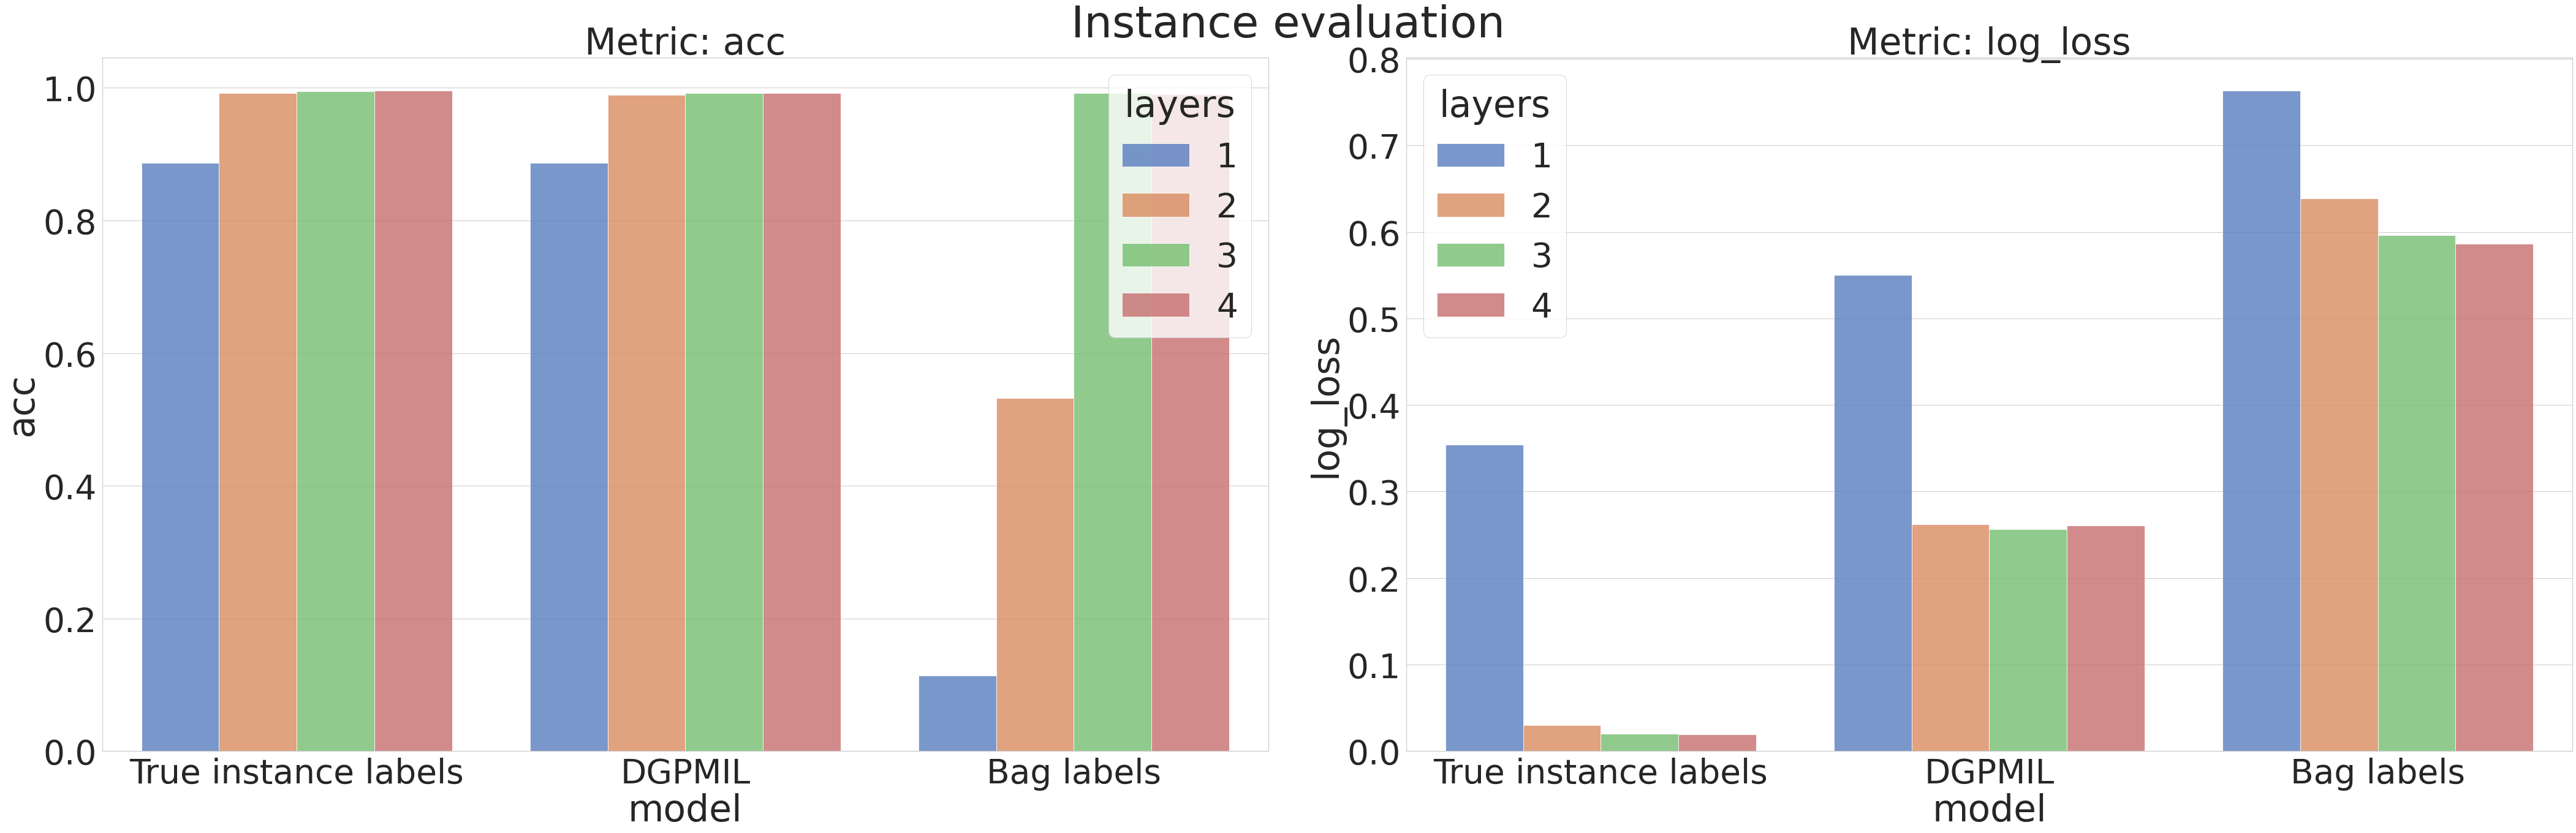

In [ ]:
# Models metrics is a list of dataframes
models_metrics=[]

for i in range(4):
    models_metrics.append(pd.concat([pd.DataFrame(DGP_metrics_true[i], index=[i]),
                                     pd.DataFrame(DGPMIL_metrics[i], index=[i]),
                                     pd.DataFrame(DGP_metrics[i], index=[i])]))
    
# Results by metrics
models_metrics2 = []

sns.set(font_scale=5)
sns.set_style("whitegrid")

for i in ["acc", "log_loss"]:
  df2 = pd.DataFrame({})
  for j in range(4):
    df_aux = pd.DataFrame(models_metrics[j][[i,"model"]])
    df_aux["layers"] = j+1
    df2 = pd.concat([df2, df_aux])
  models_metrics2.append(df2)

fig, axes = plt.subplots(1, 2, figsize=(60,20))
fig.suptitle('Instance evaluation')

for i,j in enumerate(["acc", "log_loss"]):
    sns.barplot(ax=axes[i],
    data=models_metrics2[i],
    x="model", y=j, hue="layers",
    palette="muted", alpha=.8)
    axes[i].set_title("Metric: " + j)
 

plt.tight_layout()
plt.savefig("instance_evaluation_MNIST.png")
plt.show()


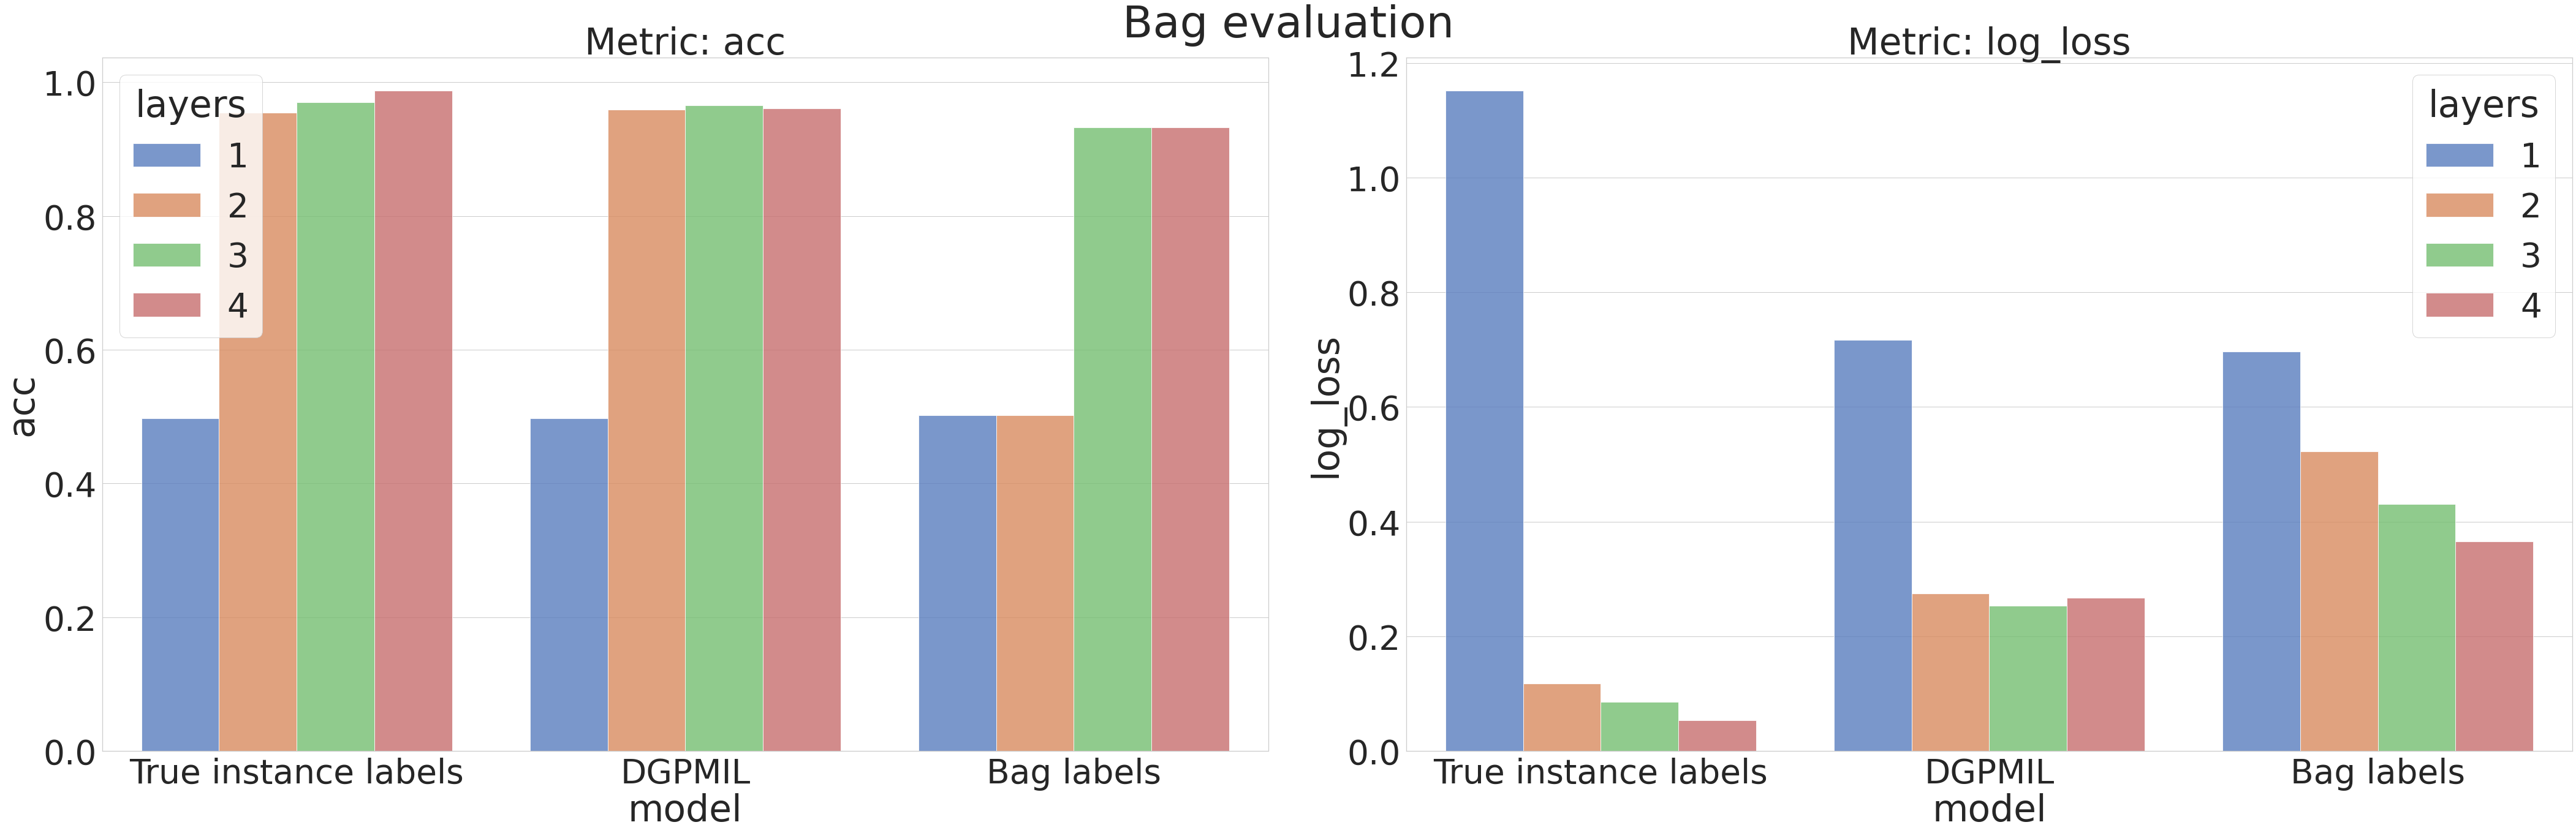

In [ ]:
# Models metrics is a list of dataframes
models_metrics_bag=[]

for i in range(4):
    models_metrics_bag.append(pd.concat([pd.DataFrame(DGP_metrics_true_bag[i], index=[i]),
                                     pd.DataFrame(DGPMIL_metrics_bag[i], index=[i]),
                                     pd.DataFrame(DGP_metrics_bag[i], index=[i])]))
    
# Results by metrics
models_metrics2 = []

for i in ["acc", "log_loss"]:
  df2 = pd.DataFrame({})
  for j in range(4):
    df_aux = pd.DataFrame(models_metrics_bag[j][[i,"model"]])
    df_aux["layers"] = j+1
    df2 = pd.concat([df2, df_aux])
  models_metrics2.append(df2)

fig, axes = plt.subplots(1, 2, figsize=(60,20))
fig.suptitle('Bag evaluation')

for i,j in enumerate(["acc", "log_loss"]):
    sns.barplot(ax=axes[i],
    data=models_metrics2[i],
    x="model", y=j, hue="layers",
    palette="muted", alpha=.8)
    axes[i].set_title("Metric: " + j)
 
plt.tight_layout()
plt.savefig("bag_evaluation_MNIST.png")
plt.show()

In the next plot, we can see the instance predictions for several samples of the test set. We can efectively check that DGPMIL achieves a considerably better test log-likelihood than using the bag labels. In this example, using the bag labels without modeling the instance labels, the model is skewed to the positive class with overconfident prediction while in DGP with true labels is capable of mantain the uncertainty. Besides, DGPMIL achieves this since it models the instance labels.

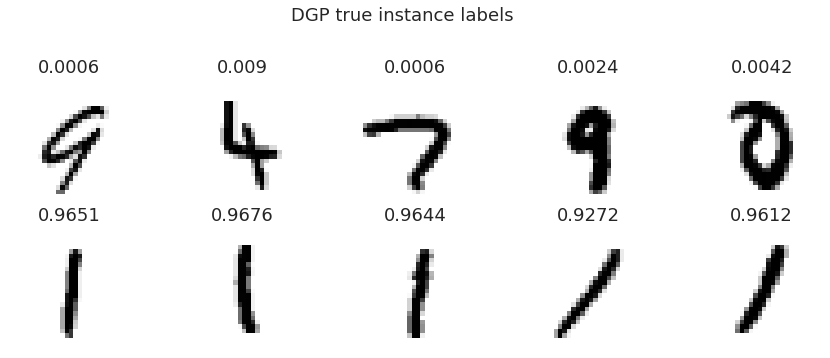

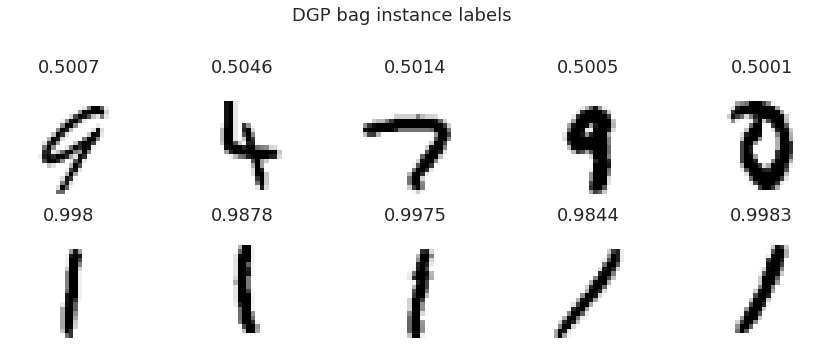

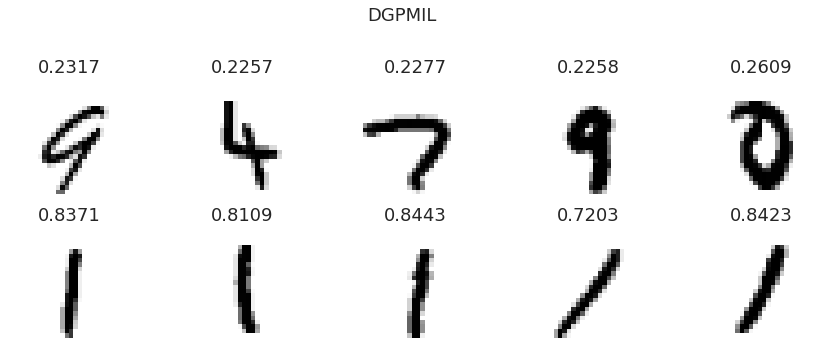

In [ ]:
def plot_pred(X_loader, model_dgp, x, y, title_model):
  """ This function plots instance predictions in test.
    Parameters
    ----------
    X : list of instances.
    bag_indexs: list with the bag indexes.
    bag_index: the index of the bag we want to plot.
    y: true instance labels.
    """
  # Select the instances of the bag
  model.eval()
  with gpytorch.settings.num_likelihood_samples(100):
    predictive_means, predictive_variances, test_lls = model_dgp.predict(X_loader)
  observed_pred = predictive_means.mean(0)
  observed_pred = observed_pred.cpu().numpy()
  
  # Calculate the bag label
  y = y.cpu().numpy()
  x = x.cpu().numpy()

  np.random.seed(4412)
  instances1 = np.random.randint(1,5000,5)
  instances2 = np.random.randint(9000,10000,5)
  instances2 = [9270, 9243, 9850, 9987, 9436]
  instances = np.hstack((instances1, instances2))
  y = y[instances]
  x = x[instances]
  observed_pred = observed_pred[instances]

  # Plot the figure
  fig = plt.figure(figsize=(15,5))
  title = title_model
  fig.suptitle(title, y=1.08, fontsize=18)
  rows = int(np.ceil(len(x)/5))
  for i in range(len(x)):
      ax = fig.add_subplot(rows, 5, i+1)
      plt.xticks([])
      plt.yticks([])
      ax.imshow(x[i].reshape(28,28), cmap='gray_r')
      #ax.set_title('Prediction: ' + str(round(observed_pred[i], 4)), fontsize=16)
      ax.set_title(str(round(observed_pred[i], 4)), fontsize=18)
  plt.savefig('pred_' + title_model + '.png')
  plt.show()

sns.set(font_scale=1)
plot_pred(test_loader, DGPtrue_models[1], test_x, test_y, 'DGP true instance labels')
plot_pred(test_loader, DGPbag_models[1], test_x, test_y, 'DGP bag instance labels')
plot_pred(test_loader, DGPMIL_models[1], test_x, test_y, 'DGPMIL')